In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/Torch/chap05/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Torch/chap05/data


In [3]:
# !unzip catanddog.zip -d catanddog/

In [4]:
data_path = 'catanddog/train/'
    
transform = transforms.Compose([transforms.Resize([256, 256]), 
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=32, 
                                           num_workers=2, 
                                           shuffle=True)

print(f"len(train_dataset): {len(train_dataset)}")

len(train_dataset): 385


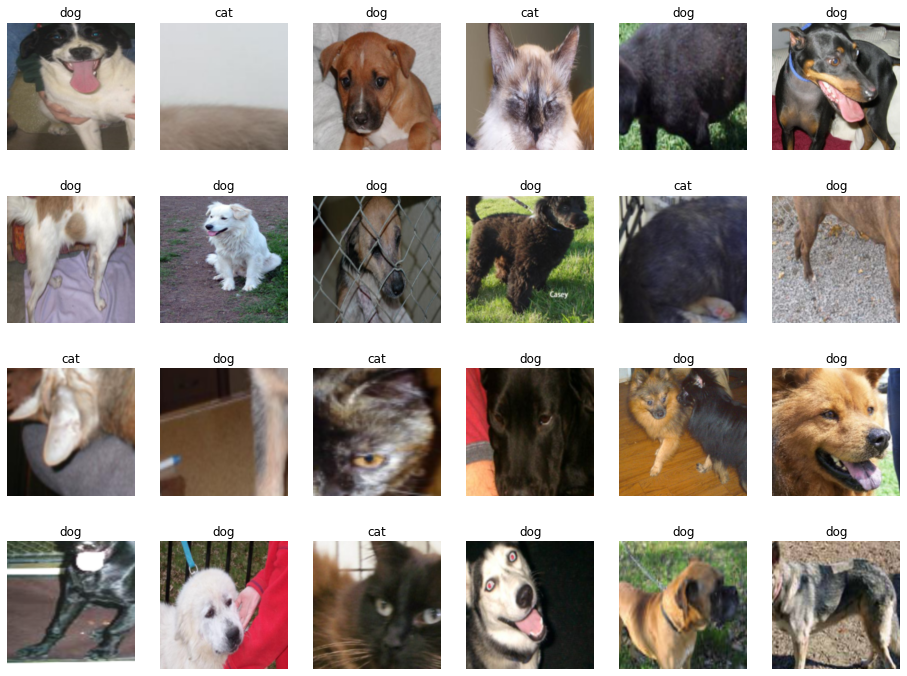

In [5]:
import numpy as np

samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(model)

In [8]:
model.fc = nn.Linear(512, 2)

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0145, -0.0390, -0.0418,  ..., -0.0111,  0.0097,  0.0049],
        [ 0.0277, -0.0066,  0.0044,  ...,  0.0019, -0.0063,  0.0197]])
fc.bias tensor([-0.0231, -0.0025])


In [10]:
# model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
# print(resnet18)

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [12]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.7120 Acc: 0.5299

Epoch 1/12
----------
Loss: 0.4411 Acc: 0.8312

Epoch 2/12
----------
Loss: 0.3975 Acc: 0.8286

Epoch 3/12
----------
Loss: 0.2842 Acc: 0.9039

Epoch 4/12
----------
Loss: 0.2950 Acc: 0.8701

Epoch 5/12
----------
Loss: 0.3260 Acc: 0.8597

Epoch 6/12
----------
Loss: 0.2400 Acc: 0.8987

Epoch 7/12
----------
Loss: 0.2493 Acc: 0.8987

Epoch 8/12
----------
Loss: 0.2431 Acc: 0.8909

Epoch 9/12
----------
Loss: 0.2537 Acc: 0.8831

Epoch 10/12
----------
Loss: 0.2491 Acc: 0.8935

Epoch 11/12
----------
Loss: 0.2195 Acc: 0.9273

Epoch 12/12
----------
Loss: 0.1782 Acc: 0.9325

Training complete in 0m 46s
Best Acc: 0.932468


In [14]:
test_path = 'catanddog/test/'

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(root=test_path, 
                                                transform=transform )
                                                
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=32, 
                                          num_workers=1, 
                                          shuffle=True)

print(f"len(test_dataset): {len(test_dataset)}")

len(test_dataset): 98


In [15]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [16]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.7959

Loading model catanddog/01.pth
Acc: 0.8980

Loading model catanddog/02.pth
Acc: 0.9286

Loading model catanddog/03.pth
Acc: 0.9286

Loading model catanddog/04.pth
Acc: 0.9388

Loading model catanddog/05.pth
Acc: 0.9388

Loading model catanddog/06.pth
Acc: 0.9286

Loading model catanddog/07.pth
Acc: 0.9388

Loading model catanddog/08.pth
Acc: 0.9286

Loading model catanddog/09.pth
Acc: 0.9490

Loading model catanddog/10.pth
Acc: 0.8878

Loading model catanddog/11.pth
Acc: 0.9184

Loading model catanddog/12.pth
Acc: 0.9082

Validation complete in 0m 11s
Best Acc: 0.948980


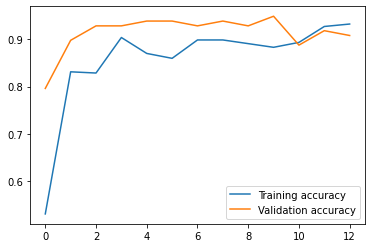

In [17]:
plt.plot(train_acc_hist, label='Training accuracy')
plt.plot(val_acc_hist, label='Validation accuracy')
plt.legend()
plt.show()

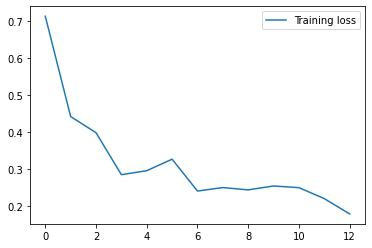

In [18]:
plt.plot(train_loss_hist, label='Training loss')
plt.legend()
plt.show()

In [19]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

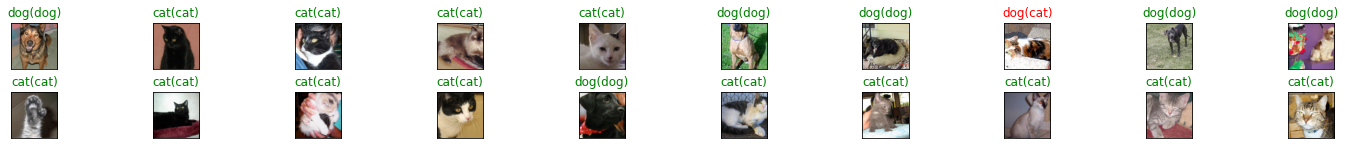

In [20]:
import numpy as np

classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)  
images, labels = dataiter.next()  
output = model(images.to(device))  
_, preds = torch.max(output,1) 

fig = plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),
                                 str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0.5)
plt.show()  